## Cross species mapping with MapMyCells

In this notebook, we will demonstrate how to map data from one species onto a taxonomy defined in another.

**Note:** in addition to the usual libraries that MapMyCells depends on, this notebook requires `scikit-learn`, `umap-learn` and `xlrd`. Run the cell below and restart your kernel if you do not have those packages installed in your environment.



In [1]:
!pip install scikit-learn umap-learn xlrd

We will take as our data, single nucleus RNA seq data from the rat ventral tegmental area as published in [Phillips et al. 2022](https://www.cell.com/cell-reports/pdf/S2211-1247(22)00364-3.pdf).

First, you must download the data from [this page](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE168156) (see the `http` link for `GSE168156_RAW.tar` at the bottom). Move the resulting `.tar` file into a directory and untar it. Store the directory as `data_dir` below.

In [2]:
import os

In [3]:
import pathlib
data_dir = pathlib.Path('data/rat')

In [4]:
expected_data_list = [
    data_dir / 'GSM5130024_F1_barcodes.tsv.gz',
    data_dir / 'GSM5130024_F1_features.tsv.gz',
    data_dir / 'GSM5130024_F1_matrix.mtx.gz',
    data_dir / 'GSM5130025_F2_barcodes.tsv.gz',
    data_dir / 'GSM5130025_F2_features.tsv.gz',
    data_dir / 'GSM5130025_F2_matrix.mtx.gz',
    data_dir / 'GSM5130026_M1_barcodes.tsv.gz',
    data_dir / 'GSM5130026_M1_features.tsv.gz',
    data_dir / 'GSM5130026_M1_matrix.mtx.gz',
    data_dir / 'GSM5130027_M2_barcodes.tsv.gz',
    data_dir / 'GSM5130027_M2_features.tsv.gz',
    data_dir / 'GSM5130027_M2_matrix.mtx.gz'
]
actual_data_list = sorted([n for n in data_dir.iterdir() if n.is_file()])
msg = ""
for pth in expected_data_list:
    if pth not in actual_data_list:
        msg += f"{pth}\n"
if len(msg) > 0:
    raise RuntimeError(
        "You seem not to have downloaded and untarred the data; the following files were missing:\n"
        f"{msg}"
    )

## Create h5ad file for mapping

The data you downloaded exists as a series of tsv and mtx files. We must collect these into a single h5ad file for mapping with MapMyCells.

Each triplet of barcodes.tsv, features.tsv, and matrix.mtx file represents data from a single donor. We will create separate AnnData objects for each of these, concatenate them into a single AnnData object, and write that out into one h5ad file.

In [5]:
working_dir = data_dir / 'working'
if not working_dir.exists():
    working_dir.mkdir(parents=True)

In [6]:
import anndata
import gzip
import numpy as np
import scipy.sparse
import pandas as pd
import re

The barcodes.tsv file is just a list of barcodes. These are the labels of the cells taken from the donor, **which are only unique to this donor**.

The features.tsv file lists the genes. It has three columns: the ENSEMBL ID of the gene, the gene symbol, and an annotation describing the type of gene.

The matrix.mtx file contains the actual gene expression data. It has three columns:
- gene_index
- cell_index (relative to *this* mtx file)
- expression value
The cell-by-gene expression matrix is defined such that
```
matrix[cell_index, gene_index] = {expression value}
```

In [7]:
def create_anndata_obj(
        obs_prefix,
        barcode_path,
        feature_path,
        matrix_path):
    """
    Create an AnnData object for a single (barcodes, features, matrix) triplet

    Parameters
    ----------
    prefix:
        a str; prefix prepended to cell barcodes to keep them unique
        across the whole dataset
    barcode_path:
        path to the barcode.tsv file
    feature_path:
        path to the features.tsv file
    matrix_path:
        path to the matrix.mtx file

    Returns
    -------
    an anndata.AnnData object
    """
    # read in the cell barcodes; create an obs dataframe with obs_prefix prepended to the
    # barcodes.
    raw_obs = pd.read_csv(
        barcode_path,
        delimiter='\t',
        names=['barcode']
    )
    obs = pd.DataFrame([{'cell': f'{obs_prefix}_{b}'} for b in raw_obs.barcode.values]).set_index('cell')

    # create a var dataframe indexed on the ENSEMBL IDs of the genes in feature_path
    var = pd.read_csv(
        feature_path,
        delimiter='\t',
        names=['ENSEMBL', 'symbol', 'annotation']
    ).set_index('ENSEMBL')

    # create an empty array to store the cell-by-gene data
    x_arr = np.zeros((len(obs), len(var)), dtype=np.int32)

    with gzip.open(matrix_path, 'r') as src:
        _ = src.readline()
        _ = src.readline()
        header = src.readline()
    header = header.split()
    n_cells = int(header[1])
    n_genes = int(header[0])
    n_vals = int(header[2])

    # make sure the number of genes matches the shape of var
    assert n_genes == len(var)

    # make sure the number of cell matches the shape of obs
    assert n_cells == len(obs)

    data = pd.read_csv(
        matrix_path,
        delimiter=' ',
        names=['gene_idx', 'cell_idx', 'val'],
        dtype={'gene_idx': int, 'cell_idx': int, 'val': np.int32},
        skiprows=3
    )

    # make sure the number of non-zero expression values matches the metadata
    # in the header
    assert len(data) == n_vals

    # set the non-zero values in x_arr
    x_arr[data.cell_idx.values-1, data.gene_idx.values-1] = data.val.values

    # re-encode x_arr as a sparse matrix
    x_arr = scipy.sparse.csr_matrix(x_arr)

    # check again that the number of non-zero values are as expected
    assert len(x_arr.data) == n_vals

    adata = anndata.AnnData(
        X=x_arr,
        obs=obs,
        var=var
    )
    return adata

In [8]:
barcode_file_list = sorted([n for n in expected_data_list if 'barcodes' in n.name])

In [9]:
adata_list = []
for barcode_path in barcode_file_list:
    print(f'PROCESSING {barcode_path.name}')
    prefix = barcode_path.name.split('_barcode')[0]
    parent = barcode_path.parent
    feature_path = parent / barcode_path.name.replace('barcodes', 'features')
    matrix_path = parent / barcode_path.name.replace('barcodes.tsv.gz', 'matrix.mtx.gz')
    adata_list.append(
        create_anndata_obj(
            obs_prefix=prefix,
            barcode_path=barcode_path,
            feature_path=feature_path,
            matrix_path=matrix_path
        )
    )
    

PROCESSING GSM5130024_F1_barcodes.tsv.gz
PROCESSING GSM5130025_F2_barcodes.tsv.gz
PROCESSING GSM5130026_M1_barcodes.tsv.gz
PROCESSING GSM5130027_M2_barcodes.tsv.gz


Now, combine the AnnData objects we have created into one and write it out to a single file

In [10]:
query_path = working_dir / 'rat_query_data.h5ad'

In [11]:
full_adata = anndata.concat(adata_list)
full_adata.write_h5ad(
    query_path,
    compression='gzip',
    compression_opts=4
)
del full_adata

## Map the data to the Whole Mouse Brain taxonomy with MapMyCells

In order to run MapMyCells on the h5ad file we just created we are going to need some supporting files, namely
- The files that define the taxonomy itself
- A database file that will handle the mapping between the rat genes in our query data and the mouse genes in the taxonomy

The python API provided by `abc_atlas_access` will allow us to download those files.

**Note:** at the moment, we are using a wrapper of `AbcProjectCache` defined in this codebase. This is because the gene_mapper_db file has not yet been made part of an official `abc_atlas_access` release.

In [12]:
import cell_type_mapper.test_utils.cache_wrapper as cache_module
abc_cache_dir = pathlib.Path('data/abc_cache')
abc_cache = cache_module.AbcCacheWrapper.from_cache_dir(abc_cache_dir)

### Download the files defining the Whole Mouse Brain taxonomy

In [13]:
wmb_precomputed_stats_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='precomputed_stats_ABC_revision_230821'
)

wmb_query_marker_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='mouse_markers_230821'
)

### Download the sqlite database used to mape genes between species


This database contains all of the

- gene symbol to gene identifier
- NCIB to ENSEMBL
- cross-species ortholog

Relationships recognized by MapMyCells. The database is created and queried using [this codebase](https://github.com/AllenInstitute/mmc_gene_mapper). The version you are downloading represents a snapshot of the data published by NCBI and ENSEMBL as of August 4, 2025. Should you want to create your own database, [this Jupyter notebook](https://github.com/AllenInstitute/mmc_gene_mapper/blob/main/notebooks/gene_mapper_demo.ipynb) will show you how.

The path to this file will be passed in through the `gene_mapping.db_path` configuration parameter when actually mapping the data.

In [14]:
gene_mapper_db_path = abc_cache.get_data_path(
    directory='mmc-gene-mapper',
    file_name='mmc_gene_mapper.2025-08-04'
)

### Perform the mapping

In [15]:
from cell_type_mapper.cli.from_specified_markers import FromSpecifiedMarkersRunner

In [16]:
mapping_path = working_dir / 'rat_mapped_to_wmb.json'

config = {
    "precomputed_stats": {
        "path": str(wmb_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(wmb_query_marker_path)
    },
    "drop_level": "CCN20230722_SUPT",
    "query_path": str(query_path),
    "extended_result_path": str(mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [17]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "query_markers": {
    "serialized_lookup": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/mouse_markers_230821.json",
    "collapse_markers": false,
    "log_level": "ERROR"
  },
  "drop_level": "CCN20230722_SUPT",
  "flatten": false,
  "map_to_ensembl": false,
  "precomputed_stats": {
    "log_level": "ERROR",
    "path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/precomputed_stats_ABC_revision_230821.h5"
  },
  "type_assignment": {
    "n_processors": 4,
    "rng_seed": 11235813,
    "n_runners_up": 5,
    "bootstrap_factor": 0.5,
    "bootstrap_factor_lookup": null,
    "min_markers": 10,
    "log_level": "ERROR",
    "bootstrap_iteration": 100,
    "normalization": "raw",
    "chunk_size": 10000
  },
  "verbose_csv": false,
  "verbose_stdout": true,
  "nodes_to_drop": null,
  "summar

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/cli/cli_log.py:73: UserWarning: numpy's internal parallelization is enabled. This could cause independent worker processes to compete for resources, degrading performance. We recommend setting the following environment variables to '1' to improve performance
{
  "NUMEXPR_NUM_THREADS": "",
  "MKL_NUM_THREADS": "",
  "OMP_NUM_THREADS": ""
}
  warnings.warn(msg)
/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


***Checking to see if we need to map query genes onto reference dataset
====Based on 32285 genes, your input data is from species 'Balb/c mouse:10090'
Reference data belongs to species Balb/c mouse:10090
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Balb/c mouse:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 20203 genes, your input data is from species 'brown rat:10116'
Input genes are from species 'brown rat:10116'
Mapping 12680 input genes from 'symbols' to 'NCBI' (e.g. ['ENSRNOG00000046319' 'ENSRNOG00000047964' 'ENSRNOG00000050370'
 'ENSRNOG00000032365' 'ENSRNOG00000058808'])
Mapping input genes from 'ENSEMBL' to 'NCBI'
Mapping genes from species 'brown rat:10116' to 'Balb/c mouse:10090'
Mapping input genes from 'NCBI' to 'ENSEMBL'
***Mapping of query genes to reference dataset comple

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/cli/cli_log.py:73: UserWarning: 1369 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


BENCHMARK: spent 3.5823e-01 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.


/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/diff_exp/score_utils.py:303: UserWarning: precomputed stats file does not have 'ge1' data
  warnings.warn("precomputed stats file does not have 'ge1' data")


BENCHMARK: spent 5.0063e+01 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
CPU times: user 32.9 s, sys: 28.6 s, total: 1min 1s
Wall time: 1min 7s


## Examine mapping results

First, let's read in the mapping from the JSON file we created.

In [18]:
import json
with open(mapping_path, 'rb') as src:
    mapping = json.load(src)

The authors of the original analysis of the rat data provide summary statistics of the distribution of cell types found in their initial analysis [in this spreadsheet.](https://ars.els-cdn.com/content/image/1-s2.0-S2211124722003643-mmc2.xls) Since these results only characterize cells in the broadest manner, we will limit ourselves to examining the distribution of cell classes (the highest level in the Whole Mouse Brain taxonomy) as determined by MapMyCells. First, let us download the published spreadsheet.

In [19]:
import subprocess

def download_file(
        src_url,
        dst_path,
        force_download=False):
    """
    Download a file.

    Parameters
    ----------
    src_url:
        URL of the file to be downloaded
    dst_path:
        path where the file will be saved
    force_download:
        if True and dst_path exists, overwrite
        (otherwise, assume dst_path is the file you want)
    """
    dst_path = pathlib.Path(dst_path)
    if force_download and dst_path.exists():
        dst_path.unlink()

    if not dst_path.is_file():
        args = [
            "wget",
            src_url,
            "-O",
            str(dst_path),
            "-q"
        ]
        p = subprocess.Popen(args)
        exit_status = p.wait()
        if exit_status != 0:
            if metadata_path.exists():
                metadata_path.unlink()
            raise RuntimeError("Failure downloading metadata file")
        print(f"SUCCESSFULLY DOWNLOADED {dst_path}")
    else:
        print(f"{dst_path} ALREADY EXISTS; NO ACTION TAKEN")

In [20]:
spreadsheet_path = working_dir / "baseline_spreadsheet.xls"
download_file(
    src_url="https://ars.els-cdn.com/content/image/1-s2.0-S2211124722003643-mmc2.xls",
    dst_path=spreadsheet_path
)

data/rat/working/baseline_spreadsheet.xls ALREADY EXISTS; NO ACTION TAKEN


In [46]:
baseline_df = pd.read_excel(
    spreadsheet_path,
    sheet_name='No. Cells by CellType by GEM'
).rename({'CellType': 'Rat cell type'}, axis=1)

In [47]:
print(baseline_df)

     Rat cell type  Fem1  Fem2  Male1  Male2  Total 
0           Olig-1  2052  1712    861   1874    6499
1           Olig-2   892   982    573    858    3305
2    Glut-Neuron-1   601   521    738   1137    2997
3        Astrocyte   630   529    289   1122    2570
4   Polydendrocyte   429   354    288    501    1572
5        Microglia   282   298    186    328    1094
6    GABA-Neuron-1   223   246    197    253     919
7    Glut-Neuron-2   238    16    141    303     698
8    GABA-Neuron-3    88   130     72    114     404
9        DA-Neuron    95   103     74    127     399
10   GABA-Neuron-2   104   139     65     89     397
11      OPC-Olig-1    59    43     66     98     266
12      OPC-Olig-2    90     9     22     26     147
13   Glut-Neuron-3    38    40     19     39     136
14           Mural    37    19     31     47     134
15     Endothelial    13     9      6     35      63


Now, let's look at the distribution found by MapMyCells.

The cell type assignments made my MapMyCells are refferred to using stable, unique, machine-readable identifiers. We will instantiate the `TaxonomyTree` class from the MapMyCells codebase to translate those machine-readable identifiers into human-readable cell type names.

In [23]:
import cell_type_mapper.taxonomy.taxonomy_tree as tree_module
taxonomy_tree = tree_module.TaxonomyTree(data=mapping['taxonomy_tree'])

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


In [24]:
level = 'CCN20230722_CLAS'
mouse_classes = np.array([

    # map machine-readable identifiers into human-readable names
    taxonomy_tree.label_to_name(
        level=level,
        label=cell[level]['assignment']
    )

    for cell in mapping['results']
])

Plot a histogram of the frequency of different cell type class assignments in our mapped data.

In [25]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'N cells')

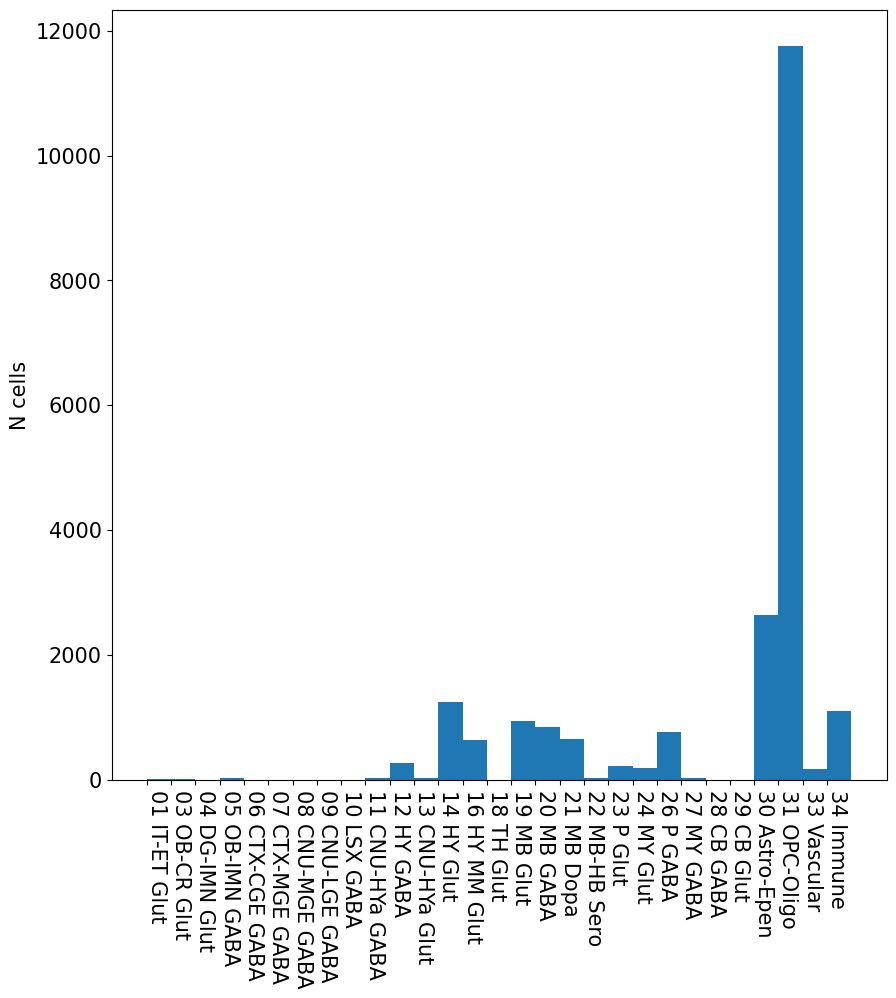

In [26]:
fontsize = 15
assignment_val = sorted(set(mouse_classes))
assignment_to_idx = {a: ii for ii, a in enumerate(assignment_val)}
assn_idx = [assignment_to_idx[a] for a in mouse_classes]
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1,1,1)
_ = axis.hist(assn_idx, np.arange(len(assignment_val)+1))
ticks = [ii for ii in range(len(assignment_val))]
axis.set_xticks(ticks, assignment_val, va='top', ha='left')
axis.tick_params(
    which='both',
    axis='both',
    labelsize=fontsize
)
axis.tick_params(
    axis='x',
    labelrotation=-90.0
)
axis.set_ylabel('N cells', fontsize=fontsize)


The Whole Mouse Brain taxonomy obviously breaks down GABA and Glut cells into a much finer set of cell type classes than does the original rat taxonomy. Let's look at the distribution if we aggregate cell classes based on the occurence of neurotransmitters in their names.

In [27]:
gross_distribution = dict()
for cell in mouse_classes:
    assigned_nt = False
    for nt in ('GABA', 'Glut', 'Dopa', 'Sero'):
        if nt in cell:
            cell = nt
            assgined_nt = True
            break

    # if no obvious neurotransmitter, just drop the
    # integer prefix from the cell type name
    if not assigned_nt:
        prefix = cell.split()[0]
        cell = cell.replace(f'{prefix} ', '')
    
    if cell not in gross_distribution:
        gross_distribution[cell] = 0
    gross_distribution[cell] += 1
    
gross_distribution = pd.DataFrame(
    [{'Mouse cell type': cell, 'Total': gross_distribution[cell]}
     for cell in gross_distribution]
).sort_values('Mouse cell type', axis=0)

print(gross_distribution)

  Mouse cell type  Total
4      Astro-Epen   2637
5            Dopa    656
3            GABA   1989
1            Glut   3273
2          Immune   1107
0       OPC-Oligo  11748
7            Sero     29
6        Vascular    167


In [48]:
print(baseline_df.sort_values('Rat cell type', axis=0))

     Rat cell type  Fem1  Fem2  Male1  Male2  Total 
3        Astrocyte   630   529    289   1122    2570
9        DA-Neuron    95   103     74    127     399
15     Endothelial    13     9      6     35      63
6    GABA-Neuron-1   223   246    197    253     919
10   GABA-Neuron-2   104   139     65     89     397
8    GABA-Neuron-3    88   130     72    114     404
2    Glut-Neuron-1   601   521    738   1137    2997
7    Glut-Neuron-2   238    16    141    303     698
13   Glut-Neuron-3    38    40     19     39     136
5        Microglia   282   298    186    328    1094
14           Mural    37    19     31     47     134
11      OPC-Olig-1    59    43     66     98     266
12      OPC-Olig-2    90     9     22     26     147
0           Olig-1  2052  1712    861   1874    6499
1           Olig-2   892   982    573    858    3305
4   Polydendrocyte   429   354    288    501    1572


At these gross levels, the distribution between rat cell types found in the original paper and mouse cell types found by MapMyCells appear very comparable.

## Visualize in UMAP

Now, let's see what the distribution of MapMyCells labels (again at the "class" level) looks like in a UMAP embedding.

In [29]:
import sklearn
import umap
import cell_type_mapper.cell_by_gene.utils as cell_by_gene_utils

Use our `AbcProjectCache` instance to download the CSV file containing the canonical mapping between cell types and colors.

In [30]:
cluster_annotation_term_df = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_annotation_term'
)

Create an easy-to-use dict allowing us to map between cell types and colors.

In [31]:
color_lookup = dict()
for node, level, color in zip(cluster_annotation_term_df.label.values,
                              cluster_annotation_term_df.cluster_annotation_term_set_label.values,
                              cluster_annotation_term_df.color_hex_triplet.values):
    if level not in color_lookup:
        color_lookup[level] = dict()
    name = taxonomy_tree.label_to_name(
        level=level,
        label=node
    )
    color_lookup[level][name] = color

In [32]:
def create_embedding(
        data,
        n_pca=0,
        n_genes=0,
        umap_metric='cosine',
        n_epochs=1000,
        learning_rate=1.0):
    """
    Create a 2-D embedding by selecting the top N genes from the top M eigenvectors
    of the data's covariance matrix.

    Parameters
    ----------
    data:
        the (n_cells, n_genes) array of expression data
    n_pca:
        befor running the UMAP embedding, find the top n_pca
        principal components characterizing the data
    n_genes:
        loop over the n_pca principal components. Find the n_genes
        genes the contribute the most to those components. Downsample
        the data to keep only these genes.
    umap_metric:
        the metric to use when assessing similarity of points
        (see umap.UMAP documentation)
    n_epochs:
        number of learning epochs umap runs through
        (see umap.UMAP documentation)
    learning_rate:
        initial umap learning rate
        (see umap.UMAP documentation)

    Returns
    -------
    a (n_cells, 2) array representing the UMAP embedding of the data.
    """
    if n_pca > 0:
        assert n_genes > 0
        pca = sklearn.decomposition.PCA(n_components=n_pca, random_state=8711231)
        pca.fit(data)
        sum_vectors = (pca.components_**2).sum(axis=0)
        assert sum_vectors.shape == (data.shape[1], )
        sorted_idx = np.argsort(sum_vectors)[-1::-1]
        chosen_idx = sorted_idx[:n_genes]
        xx = data[:, chosen_idx]
        #xx = pca.fit_transform(data)
    else:
        xx = data
    umapper = umap.UMAP(random_state=781321, metric=umap_metric, n_epochs=n_epochs, learning_rate=learning_rate)
    umap_xx = umapper.fit_transform(xx)
    return umap_xx

In [33]:
from matplotlib.patches import Rectangle

def plot_embedding(
        cell_assignments,
        embedding_coords,
        color_lookup,
        legend=True):
    """
    Plot a 2-D embedding of cell-by-gene data colored by cell type

    Parameters
    ----------
    cell_assignments:
        an (n_cells, ) array of strings. The cell type assignments of the cells
        being plotted
    embedding_coords:
        a (n_cells, 2) array; the 2-D embedding of the cell-by-gene data
    color_lookup:
        a dict mapping the cell types in cell_assignments to colors
    legend:
        if True, plot a key mapping colors to cell types. If False (maybe
        there are too many cell types to reasonably display), do not.
    """
    rng = np.random.default_rng(22131)
    idx = np.arange(len(cell_assignments))
    rng.shuffle(idx)
    cell_assignments = np.array(cell_assignments)[idx]
    embedding_coords = embedding_coords[idx, :]
    fig = plt.figure(figsize=(10,10))
    axis = fig.add_subplot(1, 1, 1)
    color_arr = [
        color_lookup[a] for a in cell_assignments
    ]
    axis.scatter(
        embedding_coords[:, 0],
        embedding_coords[:, 1],
        c=color_arr,
        s=1
    )
    min_x = embedding_coords[:, 0].min()
    max_x = embedding_coords[:, 0].max()
    dx = max_x-min_x
    axis.set_xlim((min_x-dx/2, max_x+dx/10))
    if legend:
        color_blocks = []
        label_values = np.unique(cell_assignments)
        for val in label_values:
            color_blocks.append(Rectangle((0, 0), 1, 1, fc=color_lookup[val]))
        _ = axis.legend(color_blocks, label_values, loc='upper left')

Read in the rat cell-by-gene data and convert it to `log2({counts per million}+1)`

In [34]:
src = anndata.read_h5ad(query_path)
cell_by_gene = np.log2(
    1.0+cell_by_gene_utils.convert_to_cpm(src.X.toarray())
)

Create a 2-D embedding for the whole dataset.

In [35]:
%%time
embedding = create_embedding(
    cell_by_gene,
    n_pca=100,
    n_genes=100,
    umap_metric='correlation',
    n_epochs=2000,
    learning_rate=0.1
)

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 1min 39s, sys: 1.5 s, total: 1min 41s
Wall time: 1min 34s


Plot the embedding, coloring by the mouse cell type class assigned by MapMyCells.

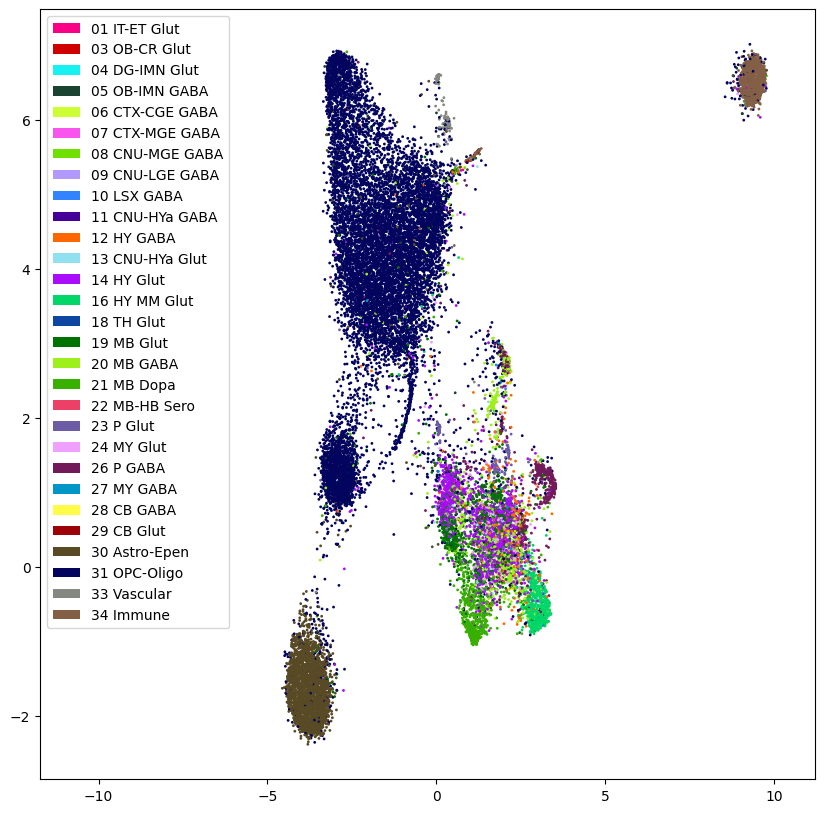

In [36]:
plot_embedding(
    cell_assignments=mouse_classes,
    embedding_coords=embedding,
    color_lookup=color_lookup['CCN20230722_CLAS'],
    legend=True)

Recall that this embedding is based solely on the rat cell-by-gene data and has no prior knowledge of the mouse taxonomy or the marker genes associated with it. The embedding seems to do a good job of separating out the non-neuronal cells. There may be some structure in the neuronal cells. To inspect this further, let's separate out the neuronal cells and try embedding them independently.

In [37]:
%%time
neuron_idx = np.array([
    ii for ii in range(len(mouse_classes))
    if 'Vascular' not in mouse_classes[ii]
    and 'Astro-Epen' not in mouse_classes[ii]
    and 'OPC-Oligo' not in mouse_classes[ii]
    and 'Immune' not in mouse_classes[ii]
])
neuron_classes = np.array(mouse_classes)[neuron_idx]
neuron_x = cell_by_gene[neuron_idx, :]

neuron_embedding = create_embedding(
    neuron_x,
    n_pca=100,
    n_genes=100,
    umap_metric='correlation',
    n_epochs=8000,
    learning_rate=0.05
)


/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 1min 27s, sys: 836 ms, total: 1min 28s
Wall time: 1min 26s


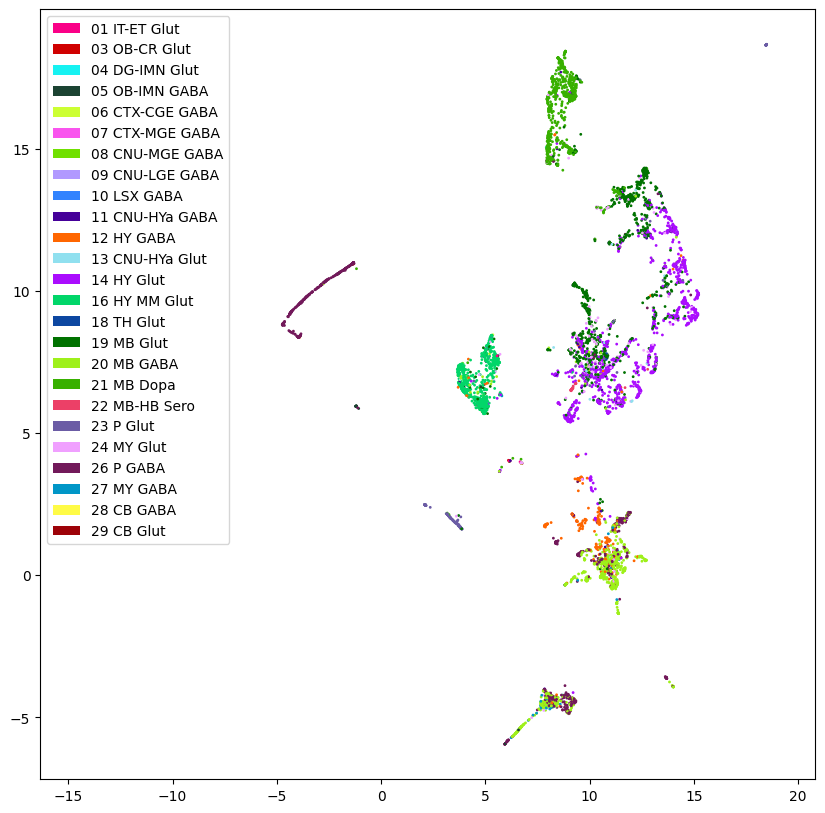

In [38]:
plot_embedding(
    cell_assignments=neuron_classes,
    embedding_coords=neuron_embedding,
    color_lookup=color_lookup['CCN20230722_CLAS'],
    legend=True)

Groups of cell type classes separate themselves out from each other, and some individual cell type classes are very distinct on their own. Let's do a brute-force mapping from cell type name to neurotransmitter to see if there is clearer structure along that axis.

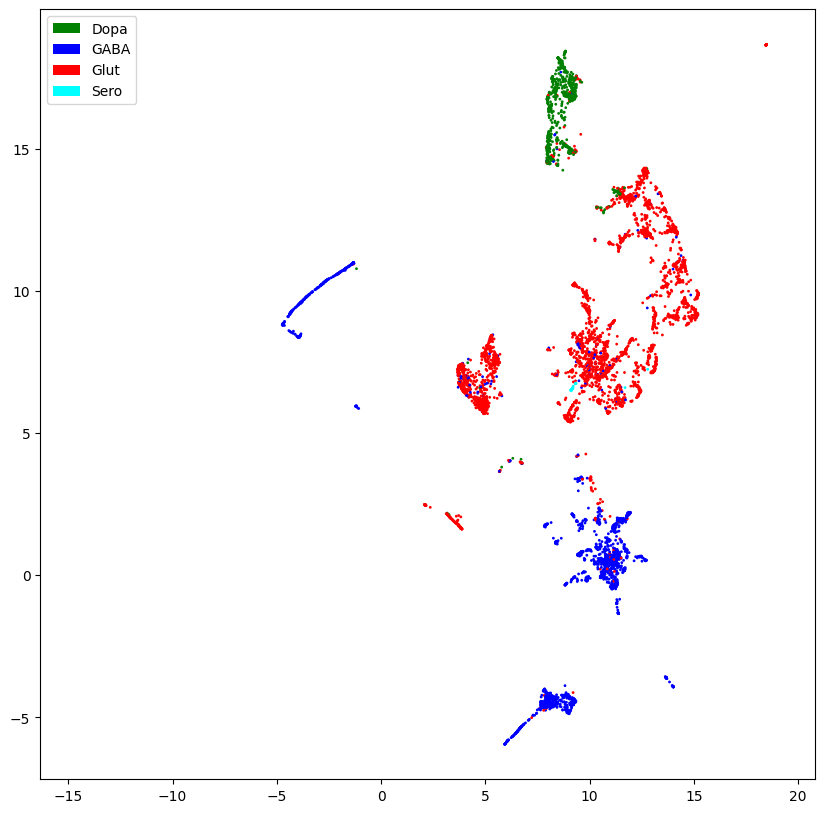

In [39]:
brute_nt = []
for cell in neuron_classes:
    nt = None
    for tag in ('GABA', 'Glut', 'Dopa', 'Sero'):
        if tag in cell:
            nt = tag
            break
    assert nt is not None
    brute_nt.append(nt)

nt_color_map = {
    'GABA': 'blue',
    'Glut': 'red',
    'Dopa': 'green',
    'Sero': 'cyan'
}
plot_embedding(
    cell_assignments=brute_nt,
    embedding_coords=neuron_embedding,
    color_lookup=nt_color_map,
    legend=True
)

The embedding does a very good job of separating out neurons corresponding to different neurotransmitters.

Again, since the embedding knew nothing about the taxonomy to which we were mapping the data, this indicates that MapMyCells has, in fact, discovered something intrinsic to the data, **even though it was mapping rat data onto a mouse taxonomy.**

## Inspecting cross-species mapping

The MapMyCells mapping result includes metadata to allow you to inspect how it handled translating your query (rat) data into the gene space of the reference (mouse) data. This can be found under `'gene_identifier_mapping'`

In [40]:
print(mapping['gene_identifier_mapping'].keys())

dict_keys(['provenance', 'mapping'])


### Provenance of mapping

The `'provenance'` field is a list detailing the data files that were used to perform the steps necessary to translate your data from one species to another.

In [49]:
print(json.dumps(mapping['gene_identifier_mapping']['provenance'], indent=2))

[
  {
    "mapping": {
      "axis": "authority",
      "from": "symbol",
      "to": "NCBI"
    },
    "citation": {
      "name": "NCBI",
      "metadata": {
        "gene_info.gz": {
          "host": "ftp.ncbi.nlm.nih.gov",
          "src_path": "gene/DATA/gene_info.gz",
          "hash": "md5:ac8399df1814b59aa6827c39b645560d",
          "downloaded_on": "2025-08-04-17-52-14"
        },
        "gene2ensembl.gz": {
          "host": "ftp.ncbi.nlm.nih.gov",
          "src_path": "gene/DATA/gene2ensembl.gz",
          "hash": "md5:4c30241f955ecdad4dd3d36464a2ea40",
          "downloaded_on": "2025-08-04-17-52-41"
        },
        "gene_orthologs.gz": {
          "host": "ftp.ncbi.nlm.nih.gov",
          "src_path": "gene/DATA/gene_orthologs.gz",
          "hash": "md5:a5d505675907c320d78712557344c7dd",
          "downloaded_on": "2025-08-04-17-52-59"
        }
      }
    }
  },
  {
    "mapping": {
      "axis": "authority",
      "from": "ENSEMBL",
      "to": "NCBI"
    },
    "

Each element in the list is a separate step in the mapping process. `'mapping'` indicates the step in the process to which we are referring. `'citation'` lists the files used. For instance

In [50]:
print(json.dumps(mapping['gene_identifier_mapping']['provenance'][1], indent=2))

{
  "mapping": {
    "axis": "authority",
    "from": "ENSEMBL",
    "to": "NCBI"
  },
  "citation": {
    "name": "NCBI",
    "metadata": {
      "gene_info.gz": {
        "host": "ftp.ncbi.nlm.nih.gov",
        "src_path": "gene/DATA/gene_info.gz",
        "hash": "md5:ac8399df1814b59aa6827c39b645560d",
        "downloaded_on": "2025-08-04-17-52-14"
      },
      "gene2ensembl.gz": {
        "host": "ftp.ncbi.nlm.nih.gov",
        "src_path": "gene/DATA/gene2ensembl.gz",
        "hash": "md5:4c30241f955ecdad4dd3d36464a2ea40",
        "downloaded_on": "2025-08-04-17-52-41"
      },
      "gene_orthologs.gz": {
        "host": "ftp.ncbi.nlm.nih.gov",
        "src_path": "gene/DATA/gene_orthologs.gz",
        "hash": "md5:a5d505675907c320d78712557344c7dd",
        "downloaded_on": "2025-08-04-17-52-59"
      }
    }
  }
}


Indicates that, when mapping from ENSEMBL IDs to NCBI IDs (all of the ortholog relationships MapMyCells recognizes are phrased in terms of NCBI IDs), MapMyCells used the three files (`'gene_info.gz`, `gene2ensembl.gz`, and `gene_orthologs.gz`) mentioned above as they were when downloaded on August 4, 2025.

You will note that, in this example, all of the `'citation'` elements are identical, since the mapping setps
- ENSEMBL to NCBI
- rate to mouse
- mouse NCBI to mouse ENSEMBL
are all defined by the suite of files published by NCBI.

### Actual gene-to-ortholog mapping

To see the actual mapping from your input genes to the reference gene space, consult the dict under `mapping['gene_identifier_mapping']['mapping']`

In [43]:
for k in src.var.index.values[:20]:
    print(k, mapping['gene_identifier_mapping']['mapping'][k])

ENSRNOG00000046319 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_0
ENSRNOG00000047964 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_1
ENSRNOG00000050370 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_2
ENSRNOG00000032365 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_3
ENSRNOG00000040300 INVALID_QUERY_GENE:ortholog:UNMAPPABLE_NO_MATCH_4
ENSRNOG00000058808 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_4
ENSRNOG00000061316 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_5
ENSRNOG00000050129 INVALID_QUERY_GENE:ENSEMBL:NCBI:UNMAPPABLE_NO_MATCH_0
ENSRNOG00000040316 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_6
ENSRNOG00000023659 INVALID_QUERY_GENE:ortholog:UNMAPPABLE_NO_MATCH_9
ENSRNOG00000029897 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_7
ENSRNOG00000042852 INVALID_QUERY_GENE:ortholog:UNMAPPABLE_NO_MATCH_11
ENSRNOG00000061806 INVALID_QUERY_GENE:ortholog:UNMAPPABLE_NO_MATCH_12
ENSRNOG00000055877 INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_8
E

In some cases, MapMyCells will be unable to find a valid ortholog for one of the genes in your input dataset. In these cases, the genes will be mapped to a unique placeholder name that does not correspond to a gene, but tries to communicate why the mapping failed. For instance

- `INVALID_QUERY_GENE:symbol:NCBI:UNMAPPABLE_NO_MATCH_0` indicates that the mapping failed when trying to map from  gene symbol to an NCBI ID (this is actually an indication that the ENSEMBL ID of this gene, `ENSRNOG00000046319`, was not present in MapMyCells' database, so it treated that ENSEMBL ID as if it were a gene symbol which it could not map)
- `INVALID_QUERY_GENE:ortholog:UNMAPPABLE_NO_MATCH_4` indicates that this gene failed when trying to find an orthologous mouse gene.

Gene mappings can also fail if there is more than one valid match, or if more than one input gene map to the same ortholog. In either case, MapMyCells will not know how to break the degeneracy.

## More questions?

Hopefully this notebook provided you with enough information to begin mapping data across species with MapMyCells. If you have any other questions, do not hesitate to post them to the MapMyCells channel in the [Allen Brain Map community forum,](https://community.brain-map.org/c/how-to/mapmycells/20) and we will respond to you promptly.